# Unitarity Calculation in QuTiP

Joel Wallman, [Christopher Granade](http://www.cgranade.com/), Robin Harper and [Steven Flammia](http://www.physics.usyd.edu.au/~sflammia/)

## Preamble

We start by ensuring division and plotting both work as expected.

In [1]:
from __future__ import division
%matplotlib inline

Next, we import NumPy and QuTiP, along with some standard library packages.

In [2]:
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt

import qutip as qt
from qutip.superop_reps import _pauli_basis

import os

We then configure QuTiP.

In [3]:
qt.settings.colorblind_safe = True

Optionally, we use mpltools to provide pretty plotting support.

In [4]:
plt.style.use('ggplot')

In [5]:
FIGPATH = '../figures/'

def savefig(fname):
    for fmt in ('pdf', 'svg', 'png'):
        plt.savefig(os.path.join(FIGPATH, '{}.{}'.format(fname, fmt)), format=fmt)

## Implementation

A numerical implementation of the unitarity $u(\mathcal{E})$ is available in the latest development versions of [QuTiP](http://qutip.org/) and [QuantumUtils for Mathematica](https://github.com/QuantumUtils/quantum-utils-mathematica) packages. We rely on QuTiP here, and briefly detail its implementation.

In [6]:
import inspect
print("".join(inspect.getsourcelines(qt.unitarity)[0]))

def unitarity(oper):
    """
    Returns the unitarity of a quantum map, defined as the Frobenius norm
    of the unital block of that map's superoperator representation.

    Parameters
    ----------
    oper : Qobj
        Quantum map under consideration.

    Returns
    -------
    u : float
        Unitarity of ``oper``.
    """
    Eu = _super_to_superpauli(oper).full()[1:, 1:]
    #return np.real(np.trace(np.dot(Eu, Eu.conj().T))) / len(Eu)
    return np.linalg.norm(Eu, 'fro')**2 / len(Eu)



This implementation begins by converting the its input to a superoperator in the Pauli basis, then proceeding according to Equation (16) in the main body. 

We check that this is correct by ensuring that the unitarity of a few different channels match our expectations.

In [7]:
print qt.unitarity(qt.to_super(qt.qeye(4)))
print qt.unitarity(qt.to_super(qt.sigmax()) / 2 + qt.to_super(qt.qeye(2)) / 2)

1.0
0.333333333333


In [8]:
depol = sum(map(qt.to_super, [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()])) / 4

In [9]:
print qt.unitarity(depol)

0.0


In [10]:
B = (_pauli_basis(1) / np.sqrt(2)).data.todense()

In [11]:
s_prep = qt.Qobj([
    [1, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], superrep='super', dims=[[[2], [2]], [[2], [2]], [[2], [2]], [[2], [2]]])

In [12]:
qt.unitarity(s_prep)

0.0

## Unitarity of Random Channels

### Histogram over Random Channels

We can also consider the unitarity of different random channels once we have this implementation in hand.

In [13]:
def random_channels(n, dim, rank=None):
    for idx in xrange(n):
        yield qt.rand_super_bcsz(dim, rank=rank)

In [14]:
unitarities = map(qt.unitarity, random_channels(5000, 2, None))

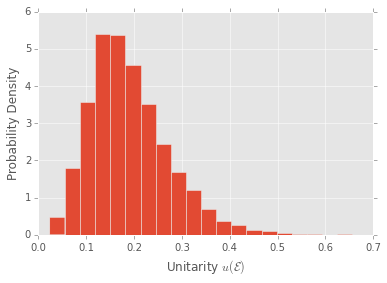

In [15]:
plt.hist(unitarities, normed='True', bins=20)
plt.xlabel(r'Unitarity $u(\mathcal{E})$')
plt.ylabel(r'Probability Density')
savefig('unitarity-hist')

### Unitarity vs Channel Rank

In [16]:
unitarities_v_rank = {rank: map(qt.unitarity, random_channels(5000, 2, rank)) for rank in [1, 2, 3, 4]}

In [17]:
bins = np.linspace(0, 1, 41)

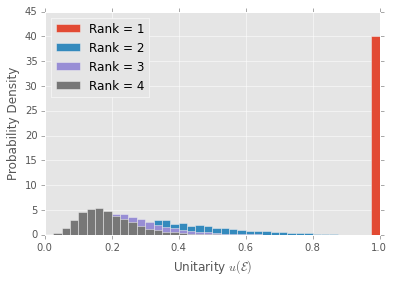

In [18]:
for rank, unis in sorted(unitarities_v_rank.items(), key=lambda a: a[0]):
    plt.hist(unis, normed=True, bins=bins, label="Rank = {}".format(rank) if rank is not None else "Full Rank")
plt.xlabel(r'Unitarity $u(\mathcal{E})$')
plt.ylabel(r'Probability Density')
plt.legend(loc='upper left')
savefig('unitarity-v-rank')

### Unitarity vs Average Gate Fidelity

We can also informally see that the unitarity tells us something different than the average gate fidelity by looking at the correlation between unitarity and average gate fidelity for a random sampling of channels. Though the two quantities are related, there are gates of the same average gate fidelity with markedly different unitarities.

In [19]:
u_v_F = np.array([
    (qt.unitarity(S), qt.average_gate_fidelity(S))
    for S in random_channels(1000, 2)
]).T

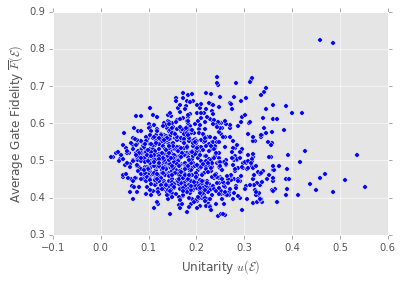

In [20]:
plt.scatter(*u_v_F)
plt.xlabel(r'Unitarity $u(\mathcal{E})$')
plt.ylabel(r'Average Gate Fidelity $\overline{F}(\mathcal{E})$')
savefig('unitarity-vs-agf')

### Decay of Unitarity

Finally, we look at the submultiplicitivity of the unitarity by drawing two random channels, and for each, plotting the unitarity of powers of the channel (solid line) versus powers of the unitarity of the original channel (dashed line).

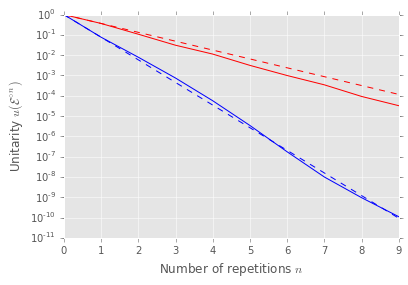

In [21]:
for S, style in zip(random_channels(2, 2, rank=None), ['r', 'b', 'm']):
    u0 = qt.unitarity(S)
    u_decay = [qt.unitarity(S ** idx) for idx in xrange(10)]
    plt.semilogy(u_decay, '-' + style)
    plt.semilogy(u0 ** np.arange(10), '--' + style)

plt.xlabel('Number of repetitions $n$')
plt.ylabel(r'Unitarity $u(\mathcal{E}^{\circ n})$')
savefig('unitarity-decay')

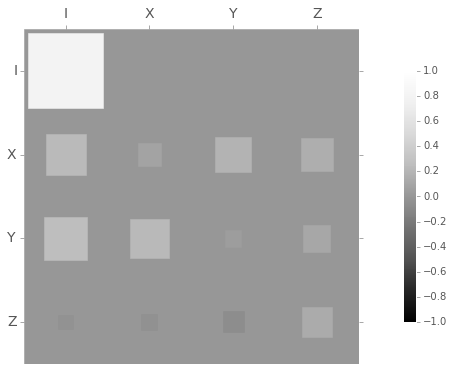

In [22]:
qt.visualization.hinton(S);